### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [1]:
env = 'colab'  # 'pc'

In [2]:
# %%capture
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/master/'

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2022-04-24 08:19:34--  https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/master/BCGDSolver.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3337 (3.3K) [text/plain]
Saving to: ‘BCGDSolver.py’

BCGDSolver.py       100%[===================>]   3.26K  --.-KB/s    in 0s      

2022-04-24 08:19:34 (27.2 MB/s) - ‘BCGDSolver.py’ saved [3337/3337]

--2022-04-24 08:19:34--  http://bcgdsolver.py/
Resolving bcgdsolver.py (bcgdsolver.py)... failed: Name or service not known.
wget: unable to resolve host address ‘bcgdsolver.py’
FINISHED --2022-04-24 08:19:34--
Total wall clock time: 0.06s
Downloaded: 1 files, 3.3K in 0s

In [3]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt




In [4]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [5]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

Data shape: X: (50, 2), Y: (50,)


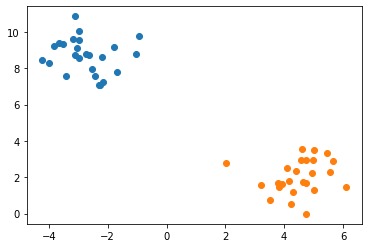

In [6]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 25 instances of object 0.0
We have to delabel 23 instances
Found 25 instances of object 1.0
We have to delabel 23 instances

    We have 46 unlabeled data
    Out of 50
    


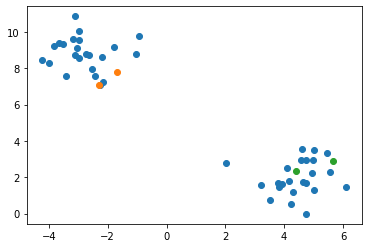

In [7]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [8]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled

# Gradient descent

In [ ]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.001
)

In [ ]:
Y_preds_GD = solver.solve(
    X,
    Y_delabeled,
    iter_limit = 60,
    delta_loss_limit = 0.001
)

Loss: 25.133279635517184, delta loss: 25.133279635517184
Loss: 24.692046825881985, delta loss: 0.4412328096351992
Loss: 24.298667083853772, delta loss: 0.3933797420282126
Loss: 23.94673438446902, delta loss: 0.3519326993847507
Loss: 23.63077100177023, delta loss: 0.31596338269879
Loss: 23.346088146351793, delta loss: 0.2846828554184384
Loss: 23.08866792244849, delta loss: 0.25742022390330277
Loss: 22.855063307403576, delta loss: 0.23360461504491425
Loss: 22.642313369598728, delta loss: 0.21274993780484763
Loss: 22.447871373983205, delta loss: 0.19444199561552367
Loss: 22.269543789721443, delta loss: 0.17832758426176198
Loss: 22.105438522836014, delta loss: 0.1641052668854286
Loss: 21.953920956937267, delta loss: 0.15151756589874665
Loss: 21.8135766047739, delta loss: 0.1403443521633676
Loss: 21.683179358736666, delta loss: 0.13039724603723357
Loss: 21.561664484968123, delta loss: 0.1215148737685432
Loss: 21.448105637880257, delta loss: 0.1135588470878659
Loss: 21.34169528348301, delta 

Accuracy: 1.0


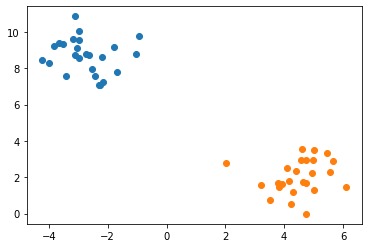

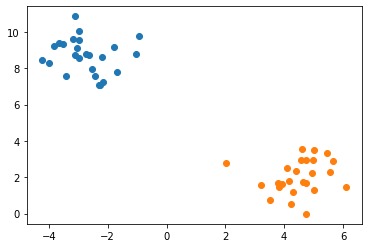

In [ ]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

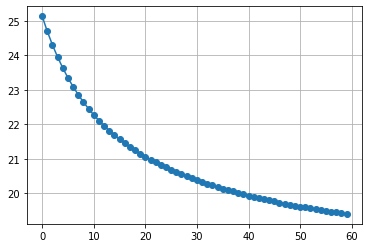

In [ ]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [ ]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [ ]:
Y_preds_BCGD_permutation = random_solver.solve(
    X,
    Y_delabeled,
    iter_limit = 50,
    delta_loss_limit = 0.008
)

LOSS: 25.133279635517184, Delta: 25.133279635517184
LOSS: 24.688928750090955, Delta: 0.44435088542622836
LOSS: 24.292725580060836, Delta: 0.3962031700301196
LOSS: 23.93822644247524, Delta: 0.35449913758559504
LOSS: 23.619920152143496, Delta: 0.3183062903317442
LOSS: 23.333126971203544, Delta: 0.2867931809399522
LOSS: 23.07386347502288, Delta: 0.25926349618066524
LOSS: 22.83861299299209, Delta: 0.23525048203078924
LOSS: 22.624349392595477, Delta: 0.21426360039661319
LOSS: 22.42852676341245, Delta: 0.19582262918302717
LOSS: 22.248947605654802, Delta: 0.17957915775764732
LOSS: 22.083713921282524, Delta: 0.1652336843722786
LOSS: 21.931181217513227, Delta: 0.15253270376929606
LOSS: 21.789917954998117, Delta: 0.14126326251511045
LOSS: 21.65871223556772, Delta: 0.1312057194303975
LOSS: 21.536506140712113, Delta: 0.1222060948556063
LOSS: 21.422344619116146, Delta: 0.11416152159596749
LOSS: 21.315401594228238, Delta: 0.10694302488790797
LOSS: 21.21497428270711, Delta: 0.10042731152112694
LOSS: 

Accuracy: 1.0


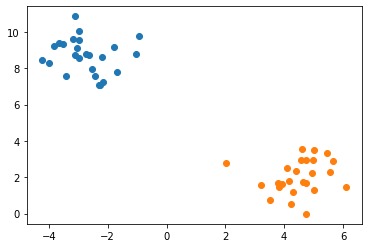

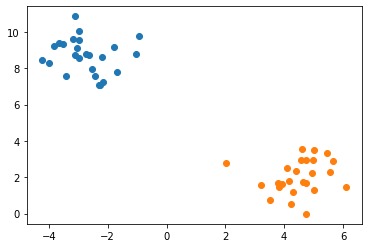

In [ ]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

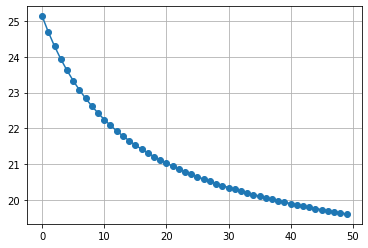

In [ ]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

## BCGD random sampling

In [ ]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.0001,
    similarity_func = None,

    bcgd_strategy = 'random sampling'
)

In [ ]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled, 
    iter_limit = 100,
    delta_loss_limit = 0.0
)

LOSS: 25.133279635517184, Delta: 25.133279635517184
LOSS: 25.132757098121914, Delta: 0.000522537395269751
LOSS: 25.132042420403273, Delta: 0.0007146777186406439
LOSS: 25.131874108074822, Delta: 0.00016831232845149202
LOSS: 25.131225183399224, Delta: 0.0006489246755982947
LOSS: 25.130654983914397, Delta: 0.0005701994848266168
LOSS: 25.130604082810503, Delta: 5.0901103893608024e-05
LOSS: 25.13048770145465, Delta: 0.00011638135585201326
LOSS: 25.13022639332561, Delta: 0.00026130812904057166
LOSS: 25.1301990680641, Delta: 2.7325261509503207e-05
LOSS: 25.129679913308056, Delta: 0.000519154756045026
LOSS: 25.129646078792142, Delta: 3.383451591432163e-05
LOSS: 25.129530437927727, Delta: 0.00011564086441495647
LOSS: 25.12949183294994, Delta: 3.860497778518379e-05
LOSS: 25.129290527837114, Delta: 0.00020130511282800967
LOSS: 25.129092109093623, Delta: 0.00019841874349069144
LOSS: 25.12869506343699, Delta: 0.0003970456566335656
LOSS: 25.1285087824718, Delta: 0.00018628096518824577
LOSS: 25.12829

Accuracy: 0.94


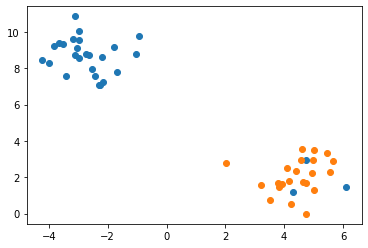

In [ ]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

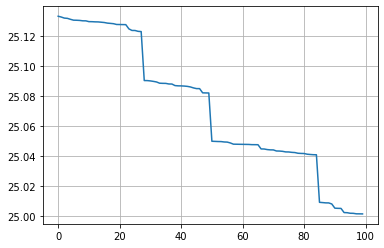

In [ ]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

## BCGD cyclic

In [ ]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'cyclic'
)

In [ ]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    iter_limit = 50, 
    delta_loss_limit = 0.0001
)

LOSS: 25.133279635517184, Delta: 25.133279635517184
LOSS: 24.688868015546948, Delta: 0.4444116199702357
LOSS: 24.292568602572377, Delta: 0.39629941297457094
LOSS: 23.93796895469215, Delta: 0.354599647880228
LOSS: 23.619581106339318, Delta: 0.31838784835283107
LOSS: 23.332703530945338, Delta: 0.28687757539398007
LOSS: 23.073304105379844, Delta: 0.2593994255654941
LOSS: 22.83792084542067, Delta: 0.23538325995917475
LOSS: 22.623577681859683, Delta: 0.21434316356098648
LOSS: 22.427712969374213, Delta: 0.19586471248547
LOSS: 22.248118777142274, Delta: 0.17959419223193862
LOSS: 22.082889311591394, Delta: 0.1652294655508797
LOSS: 21.930377076276837, Delta: 0.15251223531455693
LOSS: 21.78915558898645, Delta: 0.14122148729038742
LOSS: 21.657987657902584, Delta: 0.1311679310838656
LOSS: 21.53579837222916, Delta: 0.12218928567342502
LOSS: 21.42165209247579, Delta: 0.11414627975337055
LOSS: 21.314732835299225, Delta: 0.10691925717656403
LOSS: 21.21432754053694, Delta: 0.10040529476228599
LOSS: 21.

Accuracy: 1.0


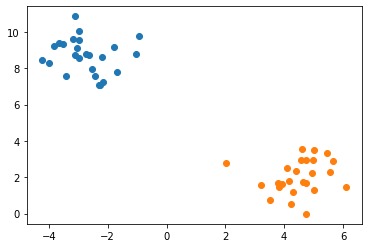

In [ ]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

In [ ]:
accuracy_score(Y, Y_preds_BCGD_cyclic)

1.0

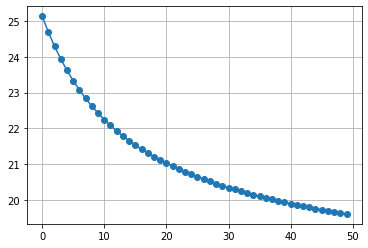

In [ ]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [9]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

In [10]:
solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    'BCGD sampling': bcgd_sampling_solver,
}

In [11]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times[model_name] = end - start
    
    # plot_accuracies(predictions)
    # plot_losses(losses)
    # plot_iterations(n_iterations)
    # plot_cpu_times(cpu_times)

    return predictions, losses, n_iterations, cpu_times

In [12]:
preds, losses, n_iters, cpu_times = compare_models(
    solvers,
    X,
    Y_delabeled,
    iters_limit = 500,
    delta_loss_limit = 0.003
)

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}

Loss: 25.133279635517184, delta loss: 25.133279635517184
Loss: 24.692046825881985, delta loss: 0.4412328096351992
Loss: 24.298667083853772, delta loss: 0.3933797420282126
Loss: 23.94673438446902, delta loss: 0.3519326993847507
Loss: 23.63077100177023, delta loss: 0.31596338269879
Loss: 23.346088146351793, delta loss: 0.2846828554184384
Loss: 23.08866792244849, delta loss: 0.25742022390330277
Loss: 22.855063307403576, delta loss: 0.23360461504491425
Loss: 22.642313369598728, delta loss: 0.21274993780484763
Loss: 22.447871373983205, delta loss: 0.19444199561552367
Loss: 22.269543789721443, delta loss: 0.17832758426176198
Loss: 22.105438522836014, delta loss: 0.1641052668854286
Loss: 21.953920956937267, delta loss: 0.15151756589874665
Loss: 21.8135766047739, delta loss: 0.1403443521633676
Loss: 21.683179358736666, delta loss: 0.13039724603723357
Loss: 21.561664484968123, delta loss: 0.1215148737685432
Loss: 21.448105637880257, delta loss: 0.1135588470878659
Loss: 21.34169528348301, delta 

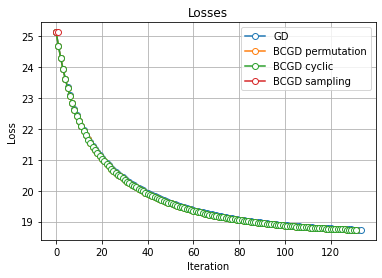

In [13]:
def plot_curves(curves_dict, title, y_label):
    _, ax = plt.subplots()

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            markerfacecolor = 'white'   
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


plot_curves(losses, 'Losses', y_label = 'Loss')

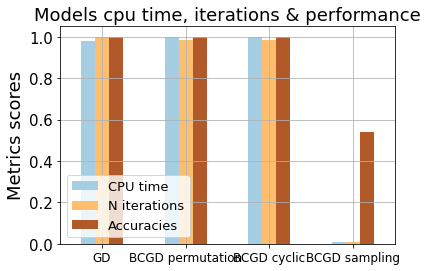

In [14]:
def plot_bar_metrics(metrics_df):
    ax = metrics_df.plot.bar(
        rot = 0,
        ylabel = 'Metrics results',
        cmap = 'Paired'
    )

    ax.set_title('Models cpu time, iterations & performance', fontsize = 18)
    ax.set_ylabel('Metrics scores', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 15)
    ax.tick_params(axis = 'x', labelsize = 12)
    ax.legend(loc = 3, prop = {'size': 13})
    plt.grid()

def normalize_cols(dataframe):
    cols = dataframe.columns
    for c in cols:
        dataframe[c] = dataframe[c] / dataframe[c].max()
    

bar_metrics = pd.DataFrame.from_dict(cpu_times, orient='index', columns = ['CPU time'])
bar_metrics['N iterations'] = n_iters.values()
bar_metrics['Accuracies'] = accuracies.values()

normalize_cols(bar_metrics)
plot_bar_metrics(bar_metrics)

# Real dataset

In [ ]:
wine=datasets.load_wine()

#Conver to pandas dataframe
data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

data = data.loc[
    (data['target'] == 1) | (data['target'] == 0),
    ['od280/od315_of_diluted_wines', 'alcohol', 'target']
]

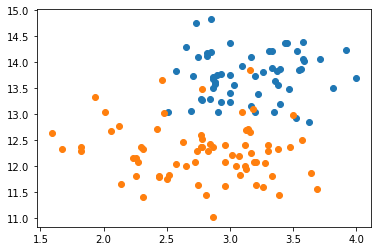

In [ ]:
X_real = data.loc[
    :,
    ['od280/od315_of_diluted_wines', 'alcohol']
].values
Y_real = data['target'].values

plot_clusters(
    X_real,
    Y_real
)

In [ ]:
Y_real_delabeled = delabel_data(
    Y_real,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

Found 59 instances of object 0.0
We have to delabel 56 instances
Found 71 instances of object 1.0
We have to delabel 67 instances


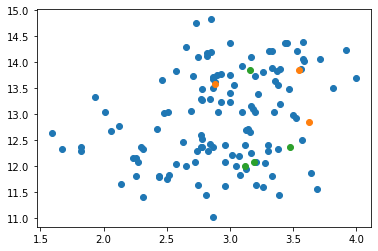

In [ ]:
plot_clusters(
    X_real,
    Y_real_delabeled
)

In [ ]:
solver = GradientDescentSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None
)

Y_real_preds = solver.solve(
    X_real,
    Y_real_delabeled,
    iter_limit=500,
    delta_loss_limit = 0.003
)

Loss: 323.8942029624401, delta loss: 323.8942029624401
Loss: 316.74220353972663, delta loss: 7.151999422713459
Loss: 313.4757742177543, delta loss: 3.266429321972339
Loss: 311.76596488709237, delta loss: 1.7098093306619262
Loss: 310.74374644924103, delta loss: 1.0222184378513361
Loss: 310.0575456186789, delta loss: 0.686200830562143
Loss: 309.55204096465934, delta loss: 0.5055046540195463
Loss: 309.15228445531534, delta loss: 0.39975650934400164
Loss: 308.81904661689146, delta loss: 0.33323783842388366
Loss: 308.5303063189672, delta loss: 0.2887402979242779
Loss: 308.2729710189335, delta loss: 0.2573353000336738
Loss: 308.0388864758443, delta loss: 0.2340845430891818
Loss: 307.8227771659063, delta loss: 0.21610930993801958
Loss: 307.6211177640279, delta loss: 0.20165940187843034
Loss: 307.43148312311644, delta loss: 0.18963464091143578
Loss: 307.25215834838053, delta loss: 0.17932477473590325
Loss: 307.0818971554001, delta loss: 0.1702611929804334
Loss: 306.9197681791677, delta loss: 0

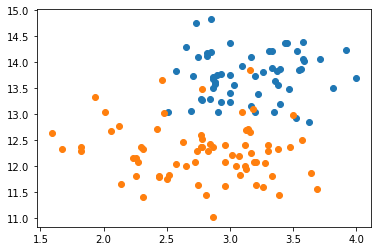

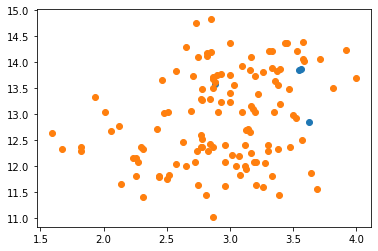

In [ ]:
plot_clusters(
    X_real,
    Y_real
)
plot_clusters(
    X_real,
    Y_real_preds
)